In [95]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

train_df = pd.read_csv('city_day.csv')

train_df['day']=pd.to_datetime(train_df.Date,format="%Y-%m-%d").dt.day
train_df['month']=pd.to_datetime(train_df.Date,format="%Y-%m-%d").dt.month
train_df['year']=pd.to_datetime(train_df.Date,format="%Y-%m-%d").dt.year

train_df.drop(['Date','City','AQI_Bucket'],axis=1,inplace=True)

## handling missing values

def fill_mean(data):#replacing null fields with the mean value of the respective filed
    null_fields = data.isna().sum()
    col = data.columns #storing the column names
    x = 0
    for i in null_fields:
        if i != 0:
            data = data.fillna({col[x]:data[col[x]].mean()})# replaces null field with mean of column values
        x += 1     
    return data

df = fill_mean(train_df)

## handling outliers

def detect_outliers_iqr(data):
    outliers = []
    data = sorted(data)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)
    for i in data: 
        if (i<lwr_bound or i>upr_bound):
            outliers.append(i)
    return outliers

def collect_outliers_iqr(data):
    outliers_detected_iqr = {}
    for i in data.columns:
        outliers = detect_outliers_iqr(data[i])
        outliers_detected_iqr[i] = outliers
    return outliers_detected_iqr


def floor_clapp_outliers(data, outliers):
    for i, j in outliers.items():
        if len(outliers[i]) != 0:
            IQR = data[i].quantile(0.75) - data[i].quantile(0.25)
            lower_bridge = data[i].quantile(0.25) - (IQR*1.5)
            upper_bridge = data[i].quantile(0.75) + (IQR*1.5)
            data.loc[data[i] > upper_bridge, i] = upper_bridge
            data.loc[data[i] < lower_bridge, i] = lower_bridge
    return data

outliers = collect_outliers_iqr(df)
df = floor_clapp_outliers(df, outliers)


## Splitting the dataset

X = df[['PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3',
       'Benzene', 'Toluene', 'Xylene','day','month','year']]
y = df['PM2.5']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=0)

In [97]:
print('X train : ',X_train.shape)
print('X test : ',X_test.shape)
print('y train : ',y_train.shape)
print('y test : ',y_test.shape)

X train :  (19195, 14)
X test :  (10336, 14)
y train :  (19195,)
y test :  (10336,)


## Feature Selection

### using pearson coefficient

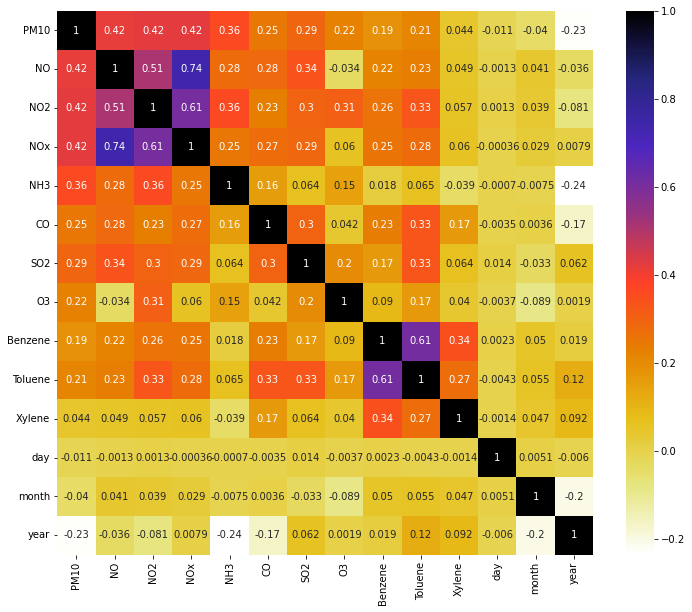

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
cor = X_train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [92]:
correlation_threshold = 70

def correlation(dataset, threshold):# Using Pearson's Correlation method-----------
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

remove_features = correlation(X_train, correlation_threshold/100)
remove_features = list(remove_features)

X_train = X_train.drop(remove_features,axis=1)
X_test = X_test.drop(remove_features,axis=1)

print(X_train.shape)
print(X_test.shape)

(19195, 13)
(10336, 13)


### Using Low Variance Threshold

In [75]:
from sklearn.feature_selection import VarianceThreshold

variance = 80

def low_variance_selection(X_train, variance):# Removing Low variance features---------------
    var_thres = VarianceThreshold(threshold = variance/100 * (1 - variance/100))
    var_thres.fit(X_train)
    
    remove_features = [column for column in X_train.columns
                    if column not in X_train.columns[var_thres.get_support()]]
    
    return remove_features

remove_features = low_variance_selection(X_train, variance)
remove_features = list(remove_features)

X_train = X_train.drop(remove_features,axis=1)
X_test = X_test.drop(remove_features,axis=1)

## using Linera Regression

In [93]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(X_train, y_train)
y_predict = model.predict(X_test)

from sklearn.metrics import r2_score, mean_absolute_error

print('R2 score : ',r2_score(y_test, y_predict))
print('mean Absolute Error: ',mean_absolute_error(y_test, y_predict))

R2 score :  0.5161283997059515
mean Absolute Error:  17.27321829371494


## Using Random Forest

In [94]:
from sklearn.ensemble import RandomForestRegressor
rfc = RandomForestRegressor(n_estimators = 150,random_state = 0)
rfc.fit(X_train, y_train)

import math
y_pred = rfc.predict(X_test)
y_pred=y_pred.round(decimals=3)
from sklearn.metrics import r2_score,mean_squared_error
print('R2 score : ',r2_score(y_test,y_pred))
print('mean Absolute Error: ',math.sqrt(mean_squared_error(np.array(y_test),y_pred)))

R2 score :  0.8288254398567054
mean Absolute Error:  14.363428389101616


In [ ]:
import numpy as np
import requests
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectPercentile

##--------------- globally declared variables --------------------------------------------------------------
#source = '/Users/siddhantj/tasks/ML Models/Jupyter files/Test/dataset-Preprocessing-Test.csv'#file name with path
source = '/Users/siddhantj/tasks/ML Models/dataset_v1.csv'#file name with path
#source = 'dirty_dataset_sample.csv'

independent_data = ['#_slices', 'req_bw_per_slice', 'req_ue_per_slice','req_per_second', 'ul_per_app',
                   'dl_per_app', 'pdu_per_slice','latency_per_app', 'packet_loss_per_app', 'rtt_per_app',
                   'jitter_per_app']

dependent_data = ['aggr_cpu', 'aggr_mem', 'aggr_disk', 'aggr_link_bw']

threshold = 95 # setting 'thres' value in dropna function(in percentage), del_cols

deviation = 3 # used in outlier detection in Z-score

TestSize = 30 #setting the size for splitting the test and train, specifying the test data size(in percentage)

correlation_threshold = 85 ## what percentage match is there among independent variables, in correlation function

variance = 85 ## used in low_variance_selection

percentile_selection = 85## used in mutual_information_selection, feature selection

MinMax_min = 0 #used in normalization

MinMax_max = 1 #used in normalization
##-------------------------------------------------------------------------------------------------------------

def download_data(source):
    req = requests.get(source)
    file = 'dataset.csv'
    url_content = req.content
    destination = open(file, 'wb')
    destination.write(url_content)
    destination.close()
    return file # returns the filename

def load_data(source):
    #data = pd.read_csv(name) # use this when accessing dataset via url
    data = pd.read_csv(source)# remove this when accessing dataset via url
    if data.empty == True:
        print('DataFrame is empty')
        exit(0)
    return data

####  +++++++++++++++++ Handling the missing values +++++++++++++++++++++++++++++++++
def del_rows(data):
    data = data.dropna()
    return data

def del_cols(data,threshold):# drops column if it has less than 'threshold'% of non-null fields
    data = data.dropna(how='any',axis=1,thresh=data.shape[0]*threshold/100)
    return data

def fill_mean(data):#replacing null fields with the mean value of the respective filed
    null_fields = data.isna().sum()
    col = data.columns #storing the column names
    x = 0
    for i in null_fields:
        if i != 0:
            data = data.fillna({col[x]:data[col[x]].mean()})# replaces null field with mean of column values
        x += 1     
    return data

def fill_median(data):#replacing null fields with the median value of the respective filed
    null_fields = data.isna().sum()
    col = data.columns #storing the column names
    x = 0
    for i in null_fields:
        if i != 0:
            data = data.fillna({col[x]:data[col[x]].median()})# replaces null field with median of column values
        x += 1
    return data

def fill_mode(data):#replacing null fields with the mode value of the respective filed
    null_fields = data.isna().sum()
    col = data.columns #storing the column names
    x = 0
    for i in null_fields:
        if i != 0:
            data = data.fillna({col[x]:data[col[x]].mode()[0]})# replaces null field with mod of column values
        x += 1   
    return data

def fill_interpolate(data):## Not useful if the multiple values from the start or end are missing ===========
    data = data.interpolate(method ='linear', limit_direction ='forward')
    data = data.interpolate(method ='linear', limit_direction ='backward')
    return data

####  +++++++++++++++++ detection & handling the outlier values ++++++++++++++++++++
def detect_outliers_zscore(data):
    outliers = []
    thres = deviation ### defined globally
    mean = np.mean(data)
    std = np.std(data)
    for i in data:
        z_score = (i-mean)/std
        if (np.abs(z_score) > thres):
            outliers.append(i)
    return outliers

def collect_outliers_zscore(data):
    outliers_detected_z = {}
    for i in data.columns:
        outliers = detect_outliers_zscore(data[i])
        outliers_detected_z[i] = outliers
    return outliers_detected_z # returns a dictionary, containing column names and respective outliers

def detect_outliers_iqr(data):
    outliers = []
    data = sorted(data)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)
    for i in data: 
        if (i<lwr_bound or i>upr_bound):
            outliers.append(i)
    return outliers

def collect_outliers_iqr(data):
    outliers_detected_iqr = {}
    for i in data.columns:
        outliers = detect_outliers_iqr(data[i])
        outliers_detected_iqr[i] = outliers
    return outliers_detected_iqr # returns a dictionary, containing column names and respective outliers

def drop_rows_outliers(data, outliers):# takes the dataframe and outliers dictionary as parameters
    for i, j in outliers.items():
        if len(outliers[i]) != 0:
            for x in j:
                data.drop(data[data[i] == x].index, inplace = True)
    return data

def floor_clapp_outliers(data, outliers):
    for i, j in outliers.items():
        if len(outliers[i]) != 0:
            IQR = data[i].quantile(0.75) - data[i].quantile(0.25)
            lower_bridge = data[i].quantile(0.25) - (IQR*1.5)
            upper_bridge = data[i].quantile(0.75) + (IQR*1.5)
            data.loc[data[i] > upper_bridge, i] = upper_bridge
            data.loc[data[i] < lower_bridge, i] = lower_bridge
    return data

def impute_mean_outlier(data, outliers):
    for i, j in outliers.items():
        if len(outliers[i]) != 0:
            for x in j:
                data[i] = data[i].replace(x, data[i].mean())
    return data

def impute_median_outlier(data, outliers):
    for i, j in outliers.items():
        if len(outliers[i]) != 0:
            for x in j:
                data[i] = data[i].replace(x, data[i].median())
    return data

def impute_mode_outlier(data, outliers):
    for i, j in outliers.items():
        if len(outliers[i]) != 0:
            for x in j:
                data[i] = data[i].replace(x, data[i].mode()[0])
    return data

####  +++++++++++++++++ separating variables & Splitting the dataset +++++++++++++++
def split(data,independent,dependent,TestSize):## TestSize defined globally
    X = data[independent]# stores the dataframe containing dependent variables only
    Y = data[dependent]
    X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=TestSize/100,random_state=42)
    # splitting the datasets into two parts , test part and train part for each X and Y,
    #random_state = 42 for best result
    
    return [X_train, X_test, Y_train,Y_test]

####  +++++++++++++++++ Feature Selection ++++++++++++++++++++++++++++++++++++++++++
def correlation(dataset, threshold):# Using Pearson's Correlation method-----------
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

def low_variance_selection(X_train, variance):# Removing Low variance features---------------
    var_thres = VarianceThreshold(threshold = variance/100 * (1 - variance/100))
    var_thres.fit(X_train)
    
    remove_features = [column for column in X_train.columns
                    if column not in X_train.columns[var_thres.get_support()]]
    
    return remove_features

def mutual_information_selection(X_train, Y_train, percentile_selection):# Information gain - mutual information
    
    selected_top_columns = SelectPercentile(mutual_info_regression, percentile=percentile_selection)
    
    mutual_dict = {}
    
    for i in Y_train.columns:
        selected_top_columns.fit(X_train, Y_train[[i]])
        mutual_dict[i] = X_train.columns[selected_top_columns.get_support()]
    
    dict_len = []
    
    for i,j in mutual_dict.items():
        a = len(j)
        dict_len.append(a)

    num = max(dict_len)
    
    selected_top_columns = []
    
    for i,j in mutual_dict.items():
        if len(j) == num:
            for k in j:
                selected_top_columns.append(k)
            break
    
    remove_features = [i for i in X_train.columns if i not in selected_top_columns]
    
    return remove_features

####  +++++++++++++++++ Selected Feature Scaling  ++++++++++++++++++++++++++++++++++

## Normalization or Min-Max Scaling----------------------------------------
def normalize_x(X_train,X_test):#----- for X part of dataset
    scaler_x = MinMaxScaler(feature_range=(MinMax_min,MinMax_max))## feature_range=(MinMax_min,MinMax_max) 
    X_train_standardized = scaler_x.fit_transform(X_train)        ### sets the range, default: (0-1) or (-1,1)
    X_test_standardized = scaler_x.transform(X_test)
    pickle.dump(scaler_x, open('scaler_x.pkl', 'wb'))
    return [X_train_standardized, X_test_standardized,scaler_x]

def normalize_y(Y_train,Y_test):#----- for Y part of dataset
    scaler_y = MinMaxScaler(feature_range=(MinMax_min,MinMax_max))## feature_range=(MinMax_min,MinMax_max) 
    Y_train_standardized = scaler_y.fit_transform(Y_train)### sets the range, default: (0-1) or (-1,1) for -ve value
    Y_test_standardized = scaler_y.transform(Y_test)
    pickle.dump(scaler_y, open('scaler_y.pkl', 'wb'))
    return [Y_train_standardized, Y_test_standardized,scaler_y]

## Standardization or Z-score Scaling---------------------------------------
def scaler_standardise_x(X_train, X_test):
    scaler_x = StandardScaler()
    X_train_standardized = scaler_x.fit_transform(X_train)
    pickle.dump(scaler_x, open('scaler_x.pkl', 'wb'))
    X_test_standardized = scaler_x.transform(X_test)
    return [X_train_standardized,X_test_standardized,scaler_x]

def scaler_standardise_y(Y_train, Y_test):
    scaler_y = StandardScaler()
    Y_train_standardized = scaler_y.fit_transform(Y_train)
    pickle.dump(scaler_y, open('scaler_y.pkl', 'wb'))
    Y_test_standardized = scaler_y.transform(Y_test)
    return [Y_train_standardized,Y_test_standardized,scaler_y]

##----------------------------------------------------------------------------------------------------------------

def handling_missing_values(data,option1):
    match option1:
        case 0 : data = del_rows(data)
        #case 1 : data = del_cols(data,threshold) ##threshold is defined globally
        case 1 : data = fill_mean(data)
        case 2 : data = fill_median(data)
        case 3 : data = fill_mode(data)
        case 4 : data = fill_interpolate(data)
        case default : data = fill_mean(data)    
    return data

def detect_handle_outliers(data, option2, option3):
    
    def detecting_outliers(data,option2):
        match option2 :
            case 0 : outliers = collect_outliers_zscore(data)
            case 1 : outliers = collect_outliers_iqr(data)
            case 2 : outliers = {}
            case default : outliers = collect_outliers_iqr(data)
        return outliers
    
    def handling_outliers(data, option3):
        match option3 :
            case 0 : data = drop_rows_outliers(data, outliers)
            case 1 : data = floor_clapp_outliers(data, outliers)
            case 2 : data = impute_mean_outlier(data, outliers)
            case 3 : data = impute_median_outlier(data, outliers)
            case 4 : data = impute_mode_outlier(data, outliers)
            case default : data = floor_clapp_outliers(data, outliers)
        return data
    
    outliers = detecting_outliers(data,option2)
    
    if option2 != 2 or option3 != 'demo':
        data = handling_outliers(data, option3)
    
    return data

def feature_selection(X_train, Y_train, option4):
    match option4:
        case 0 : remove_features = correlation(X_train, correlation_threshold/100)
        case 1 : remove_features = low_variance_selection(X_train, variance)
        case 2 : remove_features = mutual_information_selection(X_train, Y_train, percentile_selection)
        case 3 : remove_features = []
        case default : remove_features = correlation(X_train, correlation_threshold/100)
    remove_features = list(remove_features)
    return remove_features

def feature_scaling(X_train, X_test, Y_train, Y_test, option5, option6):
    if option5 == 0:
        if option6 == 0:
            normalize_list_x = normalize_x(X_train,X_test)## calls the function normalize_x
            X_train_scaled = normalize_list_x[0]
            X_test_scaled = normalize_list_x[1]
            scaler_const_x = normalize_list_x[2]
            ### ---- needed to change type from numpy array to DataFrame
            X_train = pd.DataFrame(X_train_scaled, columns = X_train.columns)
            X_test = pd.DataFrame(X_test_scaled, columns = X_test.columns)
        else:
            normalize_list_x = normalize_x(X_train,X_test)## calls the function normalize_x
            X_train_scaled = normalize_list_x[0]
            X_test_scaled = normalize_list_x[1]
            scaler_const_x = normalize_list_x[2]
            ### ---- needed to change type from numpy array to DataFrame
            X_train = pd.DataFrame(X_train_scaled, columns = X_train.columns)
            X_test = pd.DataFrame(X_test_scaled, columns = X_test.columns)
            #
            normalize_list_y = normalize_y(Y_train,Y_test)## calls the function normalize_y
            Y_train_scaled = normalize_list_y[0]
            Y_test_scaled = normalize_list_y[1]
            scaler_const_y = normalize_list_y[2]
            ## ---- needed to change type from numpy array to DataFrame
            Y_train = pd.DataFrame(Y_train_scaled, columns = Y_train.columns)
            Y_test = pd.DataFrame(Y_test_scaled, columns = Y_test.columns)   
    else:
        if option6 == 0:
            standardise_List_x = scaler_standardise_x(X_train,X_test) #---- calls the standardise function
            X_train_scaled = standardise_List_x[0] # stores X_train_standardized returned from standardise 
            X_test_scaled = standardise_List_x[1]  # stores X_test_standardized returned from standardise
            scaler_const_x = standardise_List_x[2]
            ### ---- needed to change type from numpy array to DataFrame
            X_train = pd.DataFrame(X_train_scaled, columns = X_train.columns)
            X_test = pd.DataFrame(X_test_scaled, columns = X_test.columns)
        else:
            standardise_List_x = scaler_standardise_x(X_train,X_test) #---- calls the standardise function
            X_train_scaled = standardise_List_x[0] # stores X_train_standardized returned from standardise 
            X_test_scaled = standardise_List_x[1]  # stores X_test_standardized returned from standardise
            scaler_const_x = standardise_List_x[2]
            #### ---- needed to change type from numpy array to DataFrame
            X_train = pd.DataFrame(X_train_scaled, columns = X_train.columns)
            X_test = pd.DataFrame(X_test_scaled, columns = X_test.columns)
            #
            standardise_List_y = scaler_standardise_y(Y_train,Y_test) #---- calls the standardise function
            Y_train_scaled = standardise_List_y[0] 
            Y_test_scaled = standardise_List_y[1]  
            scaler_const_y = standardise_List_y[2]
            ## ---- needed to change type from numpy array to DataFrame
            Y_train = pd.DataFrame(Y_train_scaled, columns = Y_train.columns)
            Y_test = pd.DataFrame(Y_test_scaled, columns = Y_test.columns)
    
    return [X_train, X_test, Y_train, Y_test]

def feature_scaling_specific(i,X_train, X_test, option5):
    if option5 == 0:
        scaler = MinMaxScaler(feature_range=(MinMax_min,MinMax_max))## feature_range=(MinMax_min,MinMax_max
        x_train_scaled = scaler.fit_transform(X_train[[i]])### sets the range, default:(0-1) or (-1,1)for -ve value
        x_train_scaled = pd.DataFrame(x_train_scaled, columns = [i])
        x_train_scaled.reset_index(inplace=True, drop=True)
        X_train[[i]] = x_train_scaled

        x_test_scaled = scaler.transform(X_test[[i]])
        x_test_scaled = pd.DataFrame(x_test_scaled, columns = [i])
        x_test_scaled.reset_index(inplace=True, drop=True)
        X_test[[i]] = x_test_scaled
    else:
        scaler = StandardScaler()
        x_train_scaled = scaler.fit_transform(X_train[[i]])
        x_train_scaled = pd.DataFrame(x_train_scaled, columns = [i])
        x_train_scaled.reset_index(inplace=True, drop=True)
        X_train[[i]] = x_train_scaled

        x_test_scaled = scaler.transform(X_test[[i]])
        x_test_scaled = pd.DataFrame(x_test_scaled, columns = [i])
        x_test_scaled.reset_index(inplace=True, drop=True)
        X_test[[i]] = x_test_scaled
        



##---------------------------------------------------------------------------------------------------------------

data = load_data(source)##>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

opt = input("0. Error handling in all fields"+
          '\n1. Error handling in specific field'+
           '\n2 No Error handling '+
          '(default all fields)')
if opt == "":
    opt = -1
else:
    opt = int(opt)

print()

match opt:
    case 0:
        option1 = input("Enter option for handling missing data:(default fill with mean)"+
                       '\n0.	Deleting Rows with missing values'+
                        #'\n1.	Deleting columns with missing values by setting threshold(not good results)'+
                        '\n1.	Impute missing values with Mean'+
                        '\n2.	Impute missing values with Median'+
                        '\n3.	Impute missing values with Mode'+
                        '\n4.	Interpolation of values - ')
        
        if option1 == "":
            option1 = -1
        else:
            option1 = int(option1)
            
        data = handling_missing_values(data,option1)##>>>>>>>>>>>>>>>>>>>>>>>>
        print()
        
    case 1:
        for i in data.columns:
            option1 = input("Enter option for handling missing data in "+i+" :(default fill with mean)"+
                            #'\n0.	Deleting Rows with missing values'+
                            #'\n1.	Deleting columns with missing values by setting threshold(not good results)'+
                            ## above two not suitable when handling missing values row-wise!!
                            '\n1.	Impute missing values with Mean'+
                            '\n2.	Impute missing values with Median'+
                            '\n3.	Impute missing values with Mode'+
                            '\n4.	Interpolation of values - ')
            
            if option1 == "":
                option1 = -1
            else:
                option1 = int(option1)
                
            print()
        
            data[[i]] = handling_missing_values(data[[i]],option1)##>>>>>>>>>>>>>>>>>>>>>>>>
            
    case 2:
        data = data
    
    case default:
        data = handling_missing_values(data,1)##>>>>>>>>>>>>>>>>>>>>>>>>
###
print()

opt = input("0. Detecting outliers in all fields"+
          '\n1. Detecting outliers in specific field'+
           '\n2 No outlier detection'+
          '(default all fields)')
if opt == "":
    opt = -1
else:
    opt = int(opt)

print()

match opt:
    case 0:
        option2 = input("Enter option for detecting outliers:(default IQR)"+
                        '\n0.	Detection using Z_score'+
                        '\n1.	Detection using IQR'+
                        '\n2.	No detection and handling - ')
        if option2 == "":
            option2 = -1
        else:
            option2 = int(option2)
            
        print()
        
        option3 = 'demo'
        if option2 != 2: 
            option3 = input("Enter option for handling outliers:(default flooring and capping)"+
                           '\n0.	Dropping rows with outliers '+
                            '\n1.	flooring and capping'+
                            '\n2.	Impute missing values with Mean'+
                            '\n3.	Impute missing values with Median'+
                            '\n4.	Impute missing values with Mode - ')
        if option3 == "":
            option3 = -1
        else:
            option3 = int(option3)
        
        data = detect_handle_outliers(data, option2, option3)##>>>>>>>>>>>>>>>>>>>>>>>>
        
        print()
        
    case 1:
        for i in data.columns:
            option2 = input("Enter option for detecting outlier in "+i+" :(default IQR)"+
                        '\n0.	Detection using Z_score'+
                        '\n1.	Detection using IQR'+
                        '\n2.	No detection and handling - ')
            if option2 == "":
                option2 = -1
            else:
                option2 = int(option2)
                
            print()
            
            option3 = 'demo'
            if option2 != 2: 
                option3 = input("Enter option for handling outlier in "+i+":(default flooring and capping)"+
                               ##'\n0.	Dropping rows with outliers '+ #not suitable when dealing with columns
                                '\n1.	flooring and capping'+
                                '\n2.	Impute missing values with Mean'+
                                '\n3.	Impute missing values with Median'+
                                '\n4.	Impute missing values with Mode - ')
                if option3 == "":
                    option3 = -1
                else:
                    option3 = int(option3)
        
            data[[i]] = detect_handle_outliers(data[[i]], option2, option3)##>>>>>>>>>>>>>>>>>>>>>>>>
    case 2:
        data = data
            
    case default:
        data = detect_handle_outliers(data, 1, 1)##>>>>>>>>>>>>>>>>>>>>>>>>

print()

split_data = split(data,independent_data,dependent_data,TestSize)##>>>>>>>>>>>>>>>>>>>>>>>>
# returns : [X_train, X_test, Y_train,Y_test]

X_train = split_data[0]
X_test = split_data[1]
Y_train = split_data[2]
Y_test = split_data[3]

option4 = input("Enter option for feature selection:(default: correlation)"+
                   '\n0.	Using Pearson Correlation methods'+
                '\n1.	Removing Low variance features'+
                '\n2.	Using Information gain - mutual information'+
                '\n3.	No feature selection - ')
if option4 == "":
    option4 = -1
else:
    option4 = int(option4)

remove_features = feature_selection(X_train, Y_train, option4)##>>>>>>>>>>>>>>>>>>>>>>>>

# saves the new list of features in the X_train_featured & X_test_featured dataframes.
X_train = X_train.drop(remove_features,axis=1)
X_test = X_test.drop(remove_features,axis=1)

print()

optn = input("0. Scaling in all features"+
          '\n1. Scaling in specific features'+
           '\n2 No feature scaling'+
          '(default all features using Standardization in X) - ')
if optn == "":
    optn = -1
else:
    optn = int(optn)
    
print()

match optn:
    case 0 :
        option5 = input("0. Scaling using Min-Max normalization"+
                              '\n1. Scaling using Standardisation'+
                              '(default Standardisation) - ')
        if option5 == "":
            option5 = -1
        else:
            option5 = int(option5)
        
        print()
        
        option6 = input("0. Only X part(independent features)"+
                        '\n1. Both X and Y features'+
                        '(default Both X and Y features) - ')
        if option6 == "":
            option6 = -1
        else:
            option6 = int(option6)
        scaled_list = feature_scaling(X_train, X_test, Y_train, Y_test, option5, option6)##>>>>>>>>>>>>>>>>>>>>>>>>
        # returns - [X_train, X_test, Y_train, Y_test]
        X_train = scaled_list[0]
        X_test = scaled_list[1]
        Y_train = scaled_list[2]
        Y_test = scaled_list[3]
    case 1 :
        #needed
        X_train.reset_index(inplace=True, drop=True)
        X_test.reset_index(inplace=True, drop=True)
        #
        
        print()
        
        for i in X_train.columns:
            option5 = input("For feature "+i+" , "+
                              "\n0. Scaling using Min-Max normalization"+
                              '\n1. Scaling using Standardisation'+
                              '\n2 No feature scaling'+
                              '(default Standardisation) - ')
            if option5 == "":
                option5 = -1
            else:
                option5 = int(option5)
                
            if option5 != 2:
                scaled_list = feature_scaling_specific(i,X_train, X_test, option5) ##>>>>>>>>>>>>>>>>>>>>>>>>
    case 2:
        1 == 1
    case default:
        scaled_list = feature_scaling(X_train, X_test, Y_train, Y_test, 0, 0)##>>>>>>>>>>>>>>>>>>>>>>>>
        # returns - [X_train, X_test, Y_train, Y_test]
        X_train = scaled_list[0]
        X_test = scaled_list[1]
        Y_train = scaled_list[2]
        Y_test = scaled_list[3]

print()

X_train.reset_index(inplace=True, drop=True) #### resets the index
X_test.reset_index(inplace=True, drop=True)
Y_train.reset_index(inplace=True, drop=True)
Y_test.reset_index(inplace=True, drop=True)

data_train_featured = pd.concat([X_train, Y_train], axis=1)
data_test_featured = pd.concat([X_test, Y_test], axis=1)

result = pd.concat([data_train_featured, data_test_featured])

result.to_csv('data_featured.csv', index=False)


print("Pre processed DataFrame saved as a csv file")